# Fine - Tunning HyenaDNA on Classification Task Using HELICAL

In [1]:
!nvidia-smi

Mon Sep 29 17:41:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install torchvision==0.20.0
!pip install helical --force-reinstall --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.6/209.6 MB 5.6 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.2.0
    Uninstalling triton-3.2.0:
      Successfully uninstalled triton-3.2.0
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0
    Uninstalling torch-2.6.0:
      Successfully uninstalled torch-2.6.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.23.0+cu126
    Uninstalling torchvision-0.23.0+cu126:
      Successfully uninstalled torchvision-0.23.0+cu126
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
helical 1.4.5 requires torch==2.6.0, but you have torch 2.5.0 which is incompatible.
torchaudio

  Using cached helical-1.4.5-py3-none-any.whl.metadata (55 kB)
Using cached helical-1.4.5-py3-none-any.whl (295 kB)
  Attempting uninstall: helical
    Found existing installation: helical 1.4.5
    Uninstalling helical-1.4.5:
      Successfully uninstalled helical-1.4.5


In [1]:
from helical.models.hyena_dna import HyenaDNA, HyenaDNAConfig, HyenaDNAFineTuningModel
from datasets import load_dataset
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import logging, warnings
import numpy as np

logging.getLogger().setLevel(logging.ERROR)

warnings.filterwarnings("ignore")

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:datasets:PyTorch version 2.5.0 available.
INFO:datasets:Polars version 1.25.2 available.
INFO:datasets:Duckdb version 1.3.2 available.
INFO:datasets:TensorFlow version 2.19.0 available.
INFO:datasets:JAX version 0.5.3 available.


## Using GPU if available

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Dataset Download



*   Hugging Face Dataset API
*   Dataset Can be Found Here https://huggingface.co/datasets/InstaDeepAI/nucleotide_transformer_downstream_tasks



In [ ]:
label = "promoter_tata"

dataset = load_dataset("InstaDeepAI/nucleotide_transformer_downstream_tasks",  trust_remote_code=True).filter(lambda x: x["task"] == "promoter_tata")
dataset_train = dataset["train"]
dataset_test = dataset["test"]

In [4]:
unique, counts = np.unique(dataset_train["label"], return_counts=True)
dict(zip(unique, counts))

{0: 2776, 1: 2733}

In [5]:
unique, counts = np.unique(dataset_test["label"], return_counts=True)
dict(zip(unique, counts))

{0: 289, 1: 332}

### Define our HyenaDNA fine-tuning model and configs

In [6]:
hyena_config = HyenaDNAConfig(model_name="hyenadna-tiny-1k-seqlen-d256", batch_size=10, device=device)
hyena_fine_tune = HyenaDNAFineTuningModel(hyena_config, fine_tuning_head="classification", output_size=len(np.unique(dataset_train["label"])))

hyenadna-tiny-1k-seqlen-d256.ckpt: 100%|██████████| 19.8M/19.8M [00:01<00:00, 13.8MB/s]


## Train Test Split

In [7]:
train_dataset = hyena_fine_tune.process_data(dataset_train["sequence"])
test_dataset = hyena_fine_tune.process_data(dataset_test["sequence"])

In [8]:
hyena_fine_tune.train(train_dataset=train_dataset, train_labels=dataset_train["label"], validation_dataset=test_dataset, validation_labels=dataset_test["label"], epochs=10, optimizer_params={"lr": 2e-6}, lr_scheduler_params={"name": "linear", "num_warmup_steps": 0})

Fine-Tuning Validation: 100%|██████████| 63/63 [00:00<00:00, 71.93it/s, val_loss=0.188]


### Predicting on Test Set

In [9]:
outputs = hyena_fine_tune.get_outputs(test_dataset)

100%|██████████| 63/63 [00:01<00:00, 60.35it/s]


## Evaluation Metrics

In [10]:
print(classification_report(dataset_test["label"], outputs.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       289
           1       0.93      0.95      0.94       332

    accuracy                           0.94       621
   macro avg       0.94      0.93      0.94       621
weighted avg       0.94      0.94      0.94       621



## Confusion Matrix

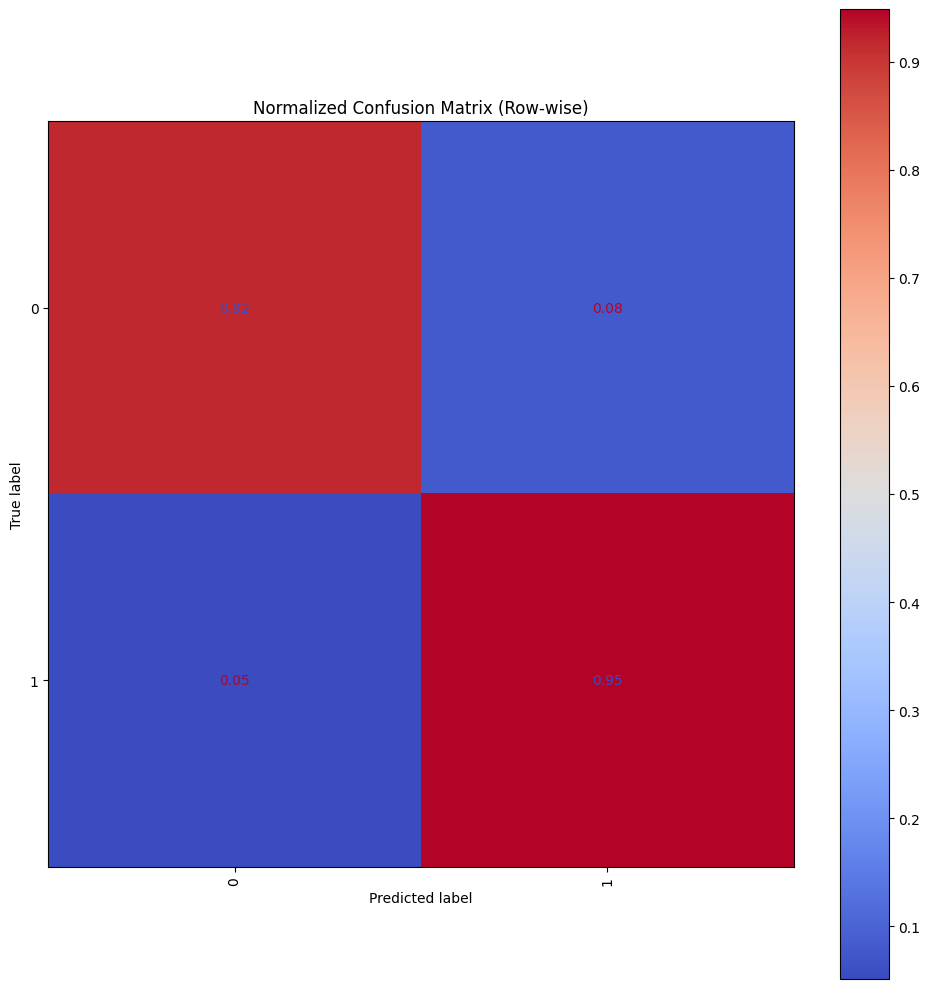

In [11]:
# Compute the confusion matrix
cm = confusion_matrix(dataset_test["label"], outputs.argmax(axis=1))

# Perform row-wise normalization
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Get unique labels in the order they appear in the confusion matrix
unique_labels = np.unique(np.concatenate((dataset_test["label"], outputs.argmax(axis=1))))

# Create and plot the normalized confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=unique_labels)
disp.plot(ax=ax, xticks_rotation='vertical', values_format='.2f', cmap='coolwarm')

# Customize the plot
ax.set_title('Normalized Confusion Matrix (Row-wise)')
fig.set_facecolor("none")

plt.tight_layout()
plt.show()

In [15]:
import torch

In [13]:
model_to_save = hyena_fine_tune.model


#### Saving Model

In [14]:
save_path = "hyenadna_promoter_tata_fine_tuned.pt"

torch.save(model_to_save.state_dict(), save_path)

print(f"Fine-tuned model weights saved to: {save_path}")

Fine-tuned model weights saved to: hyenadna_promoter_tata_fine_tuned.pt
